In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('Quality of Service 5G.csv')
df.head()

,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,9/3/2023 10:00,User_1,Video_Call,-75 dBm,30 ms,10 Mbps,15 Mbps,70%
1,9/3/2023 10:00,User_2,Voice_Call,-80 dBm,20 ms,100 Kbps,120 Kbps,80%
2,9/3/2023 10:00,User_3,Streaming,-85 dBm,40 ms,5 Mbps,6 Mbps,75%
3,9/3/2023 10:00,User_4,Emergency_Service,-70 dBm,10 ms,1 Mbps,1.5 Mbps,90%
4,9/3/2023 10:00,User_5,Online_Gaming,-78 dBm,25 ms,2 Mbps,3 Mbps,85%


#### Data Cleaning and Preprocessing

In [3]:
# First, check unique types in categorical feature: Application Type
df['Application_Type'].unique()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Timestamp            400 non-null    object
 1   User_ID              400 non-null    object
 2   Application_Type     400 non-null    object
 3   Signal_Strength      400 non-null    object
 4   Latency              400 non-null    object
 5   Required_Bandwidth   400 non-null    object
 6   Allocated_Bandwidth  400 non-null    object
 7   Resource_Allocation  400 non-null    object
dtypes: object(8)
memory usage: 25.1+ KB


With this, it shows that our data types are mostly object. We must conver it to numerics

In [4]:
# Transform this into a numerical feature
mapping = {
    'Video_Call': 1,
    'Voice_Call': 2,
    'Streaming': 3,
    'Emergency_Service': 4,
    'Online_Gaming': 5,
    'Background_Download': 6,
    'Web_Browsing': 7,
    'IoT_Temperature': 8,
    'Video_Streaming': 9,
    'File_Download': 10,
    'VoIP_Call': 11
}

df['Application_Type'] = df['Application_Type'].str.strip()
df['Application_Type'] = df['Application_Type'].map(mapping)
df.head()



,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,9/3/2023 10:00,User_1,1,-75 dBm,30 ms,10 Mbps,15 Mbps,70%
1,9/3/2023 10:00,User_2,2,-80 dBm,20 ms,100 Kbps,120 Kbps,80%
2,9/3/2023 10:00,User_3,3,-85 dBm,40 ms,5 Mbps,6 Mbps,75%
3,9/3/2023 10:00,User_4,4,-70 dBm,10 ms,1 Mbps,1.5 Mbps,90%
4,9/3/2023 10:00,User_5,5,-78 dBm,25 ms,2 Mbps,3 Mbps,85%


In [5]:
# Signal Strength
df["Signal_Strength"] = df["Signal_Strength"].str.replace(" dBm", "").astype(float)
# Latency
df["Latency"] = df["Latency"].str.replace(" ms", "").astype(float)

# Resource Allocation
df["Resource_Allocation"] = df["Resource_Allocation"].str.replace("%", "").astype(float)


# function to parse the bandwidth strings
def parse_bandwidth(bw_string):
    if "Mbps" in bw_string:
        return float(bw_string.replace(" Mbps", ""))
    elif "Kbps" in bw_string:
        # Convert from Kbps to Mbps: 1 Mbps = 1000 Kbps
        return float(bw_string.replace(" Kbps", "")) / 1000.0
    else:
        return None

df["Required_Bandwidth"] = df["Required_Bandwidth"].apply(parse_bandwidth)
df["Allocated_Bandwidth"] = df["Allocated_Bandwidth"].apply(parse_bandwidth)

df.head()



,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,9/3/2023 10:00,User_1,1,-75.0,30.0,10.0,15.00,70.0
1,9/3/2023 10:00,User_2,2,-80.0,20.0,0.1,0.12,80.0
2,9/3/2023 10:00,User_3,3,-85.0,40.0,5.0,6.00,75.0
3,9/3/2023 10:00,User_4,4,-70.0,10.0,1.0,1.50,90.0
4,9/3/2023 10:00,User_5,5,-78.0,25.0,2.0,3.00,85.0


In [6]:
# verify changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            400 non-null    object 
 1   User_ID              400 non-null    object 
 2   Application_Type     400 non-null    int64  
 3   Signal_Strength      400 non-null    float64
 4   Latency              400 non-null    float64
 5   Required_Bandwidth   400 non-null    float64
 6   Allocated_Bandwidth  400 non-null    float64
 7   Resource_Allocation  400 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 25.1+ KB


- With this, we have ommited Signal_Strength label (dBm) and Latency label (ms) for better processing of data
- We also first converted to a standard bandwidth, Mbps, then removed the label
- Also converted the Resource_Allocation to float instead of object (percentage to float)

##### Check data
- check our QoS Labels if successful
- Use heatmap to check correlation of numerical features. IF there are highly related features, more than 0.8, ommit one to eliminate redundancy.

In [12]:
# Check our data
#df.head()
#df.describe()
#print(df["QoS_Label"].value_counts())
#df.duplicated().sum()
#df.tail()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            400 non-null    object 
 1   User_ID              400 non-null    object 
 2   Application_Type     400 non-null    int64  
 3   Signal_Strength      400 non-null    float64
 4   Latency              400 non-null    float64
 5   Required_Bandwidth   400 non-null    float64
 6   Allocated_Bandwidth  400 non-null    float64
 7   Resource_Allocation  400 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 25.1+ KB


<Axes: >

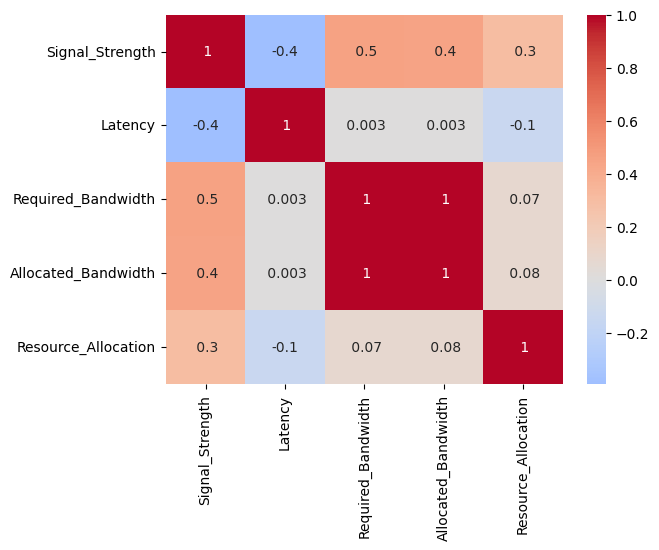

In [14]:
numeric_cols = ['Signal_Strength','Latency','Required_Bandwidth','Allocated_Bandwidth','Resource_Allocation']

# Compute correlation matrix
corr_matrix = pd.DataFrame(df[numeric_cols],columns=numeric_cols).corr()

sns.heatmap(corr_matrix,
            cmap = 'coolwarm',
            center = 0,
            annot = True,
            fmt = ' .1g')

With the heatmap above, we see that Required_Bandwith and Allocated_Bandwidth is highly correlated (1), this means we can ommit one. In this case we dont include Required_Bandwidth to remove redundancy of features

#### Train-test split
We can now split the dataset with our chosen features
Since our objective is AI-Based Bandwidth Allocation for Optimized Network Traffic

We will do a regression analysis too since our y (Resource_Allocation) is continuous, a percentage

In [24]:
features = ["Latency", "Signal_Strength", "Allocated_Bandwidth"]
X = df[features]  # Features for the model
y = df["Resource_Allocation"]  # Target: float percentage (0–100)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,     # 20% for testing
    random_state=42
)

#### Modeling
We start with Random Forest Regressor
MSE: Average squared difference between predictions and actual values (lower is better).
RMSE: Square root of MSE (often easier to interpret in the same scale as the target).
R²: Coefficient of determination (closer to 1.0 means better fit).

In [29]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    param_grid, 
    cv=5,               # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1           # use all CPU cores
)

grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate best model
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"MSE (tuned): {mse_best:.2f}, R^2: {r2_best:.2f}")



Best params: {'max_depth': None, 'n_estimators': 200}
MSE (tuned): 12.58, R^2: 0.86


With MSE around 12.58 (RMSE ≈ 3.55) and R² = 0.86, model is performing quite well at predicting Resource_Allocation from the given features.

#### Lets see feature importance using SHAP
We will use TreeExplainer from shap since RF Regressor is a tree based model

In [ ]:
import shap
# get SHAP values
explainer = shap.TreeExplainer(best_model)

In [32]:
shap_values = explainer(X) 

In [ ]:
print(np.shape(shap_values.values))
# Shows (n_samples,n_features)

(400, 3)


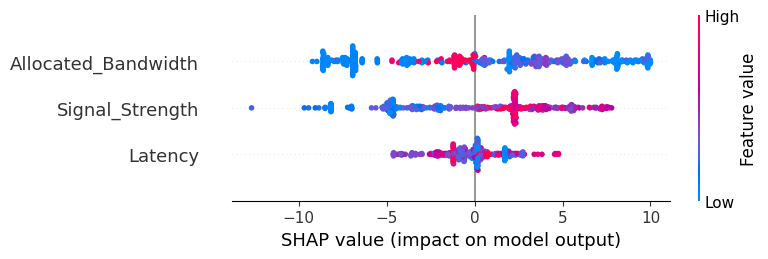

In [34]:
shap.summary_plot(shap_values.values, X)

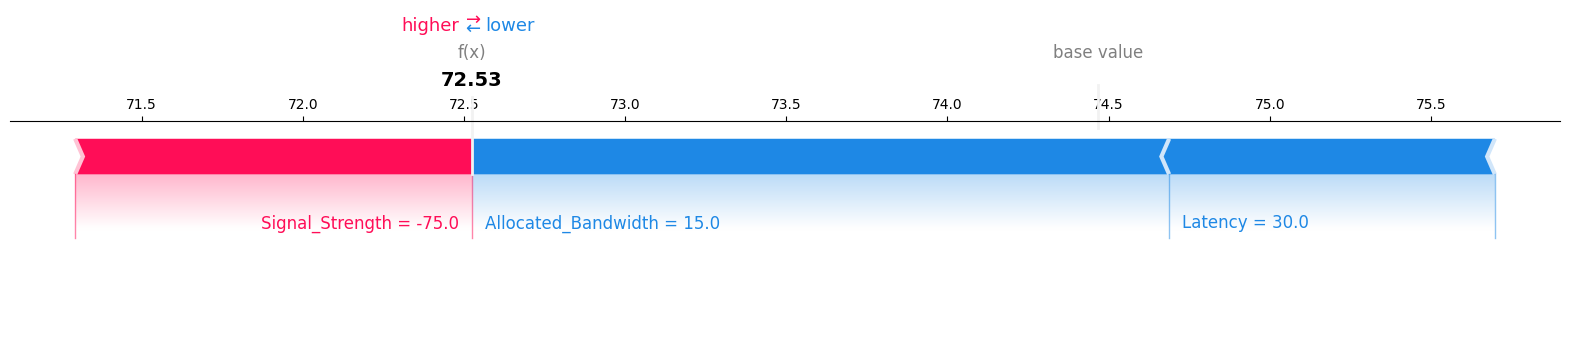

In [35]:
shap.initjs()
i = 0  # examine the first sample
shap.force_plot(
    explainer.expected_value, 
    shap_values.values[i, :], 
    X.iloc[i, :],
    matplotlib=True
)
plt.show()

According to SHAP Summary (Beeswarm) Plot
Features used: Allocated_Bandwidth, Signal_Strength, Latency
- **Allocated_Bandwidth** typically has the largest spread of SHAP values (left to right). This indicates it’s the most impactful feature overall. High allocated bandwidth (red dots to the right) tends to increase the predicted resource allocation, whereas lower allocated bandwidth (blue dots to the left) can push the prediction downward.
- **Signal_Strength** also influences predictions, but in a slightly smaller range than Allocated_Bandwidth. We see that more negative dBm (bluer or lower values) may reduce the predicted resource allocation or, in some cases, push it up depending on how it interacts with the other features.
- **Latency** appears to have the smallest global impact in this dataset (the SHAP values hover near zero more often), but it still can shift the prediction slightly up or down depending on whether Latency is high (red) or low (blue).
